# Example of Aggregating in Space vs. Time

This notebook gives an example of applying an aggregation function over space versus time on larger datasets (GB's to TB's) using dask+xarray on PO.DAAC earthdata in the AWS cloud environment. "Aggregation function" refers to computations such as mean, standard deviation.

As is common in earthdata, separate files represent the entire spatial extent of the dataset for a single (or handful) of time stamps. That is, each file contains the full spatial extent, but the full temporal extent must be accessed by loading all data files.

* For space: compare SST time series of two different ocean regions (say one tropical, one arctic). End product will be line plots of mean temperature for each of the regions.
* For time: generate std(SST) maps for each region.

**Dataset used**

MUR SST 1 km (DOI...)

**Who this notebook is for**
* Familiarity with Python and "Pythonic" syntax.
* Some basic familiarity with xarray. E.g. opening datasets, accessing and subsetting variables, applying basic functions.
* Ability to connect to AWS EC2 instances.
* Basic knowledge of parallel computing and dask clusters (if not, go to one of the previous notebooks).

**Requirements**
* Running from EC2 instance
* have a .netrc file with Earthdata Login credentials

In [1]:
import s3fs
import requests

import xarray as xr
from dask.distributed import Client, LocalCluster

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
creds = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
fs_s3 = s3fs.S3FileSystem(
    anon=False,
    key=creds['accessKeyId'],
    secret=creds['secretAccessKey'], 
    token=creds['sessionToken'],
    client_kwargs={'region_name':'us-west-2'}
    )
s3path = "s3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/"
fns = fs_s3.glob(s3path+"*.nc")

In [3]:
cluster = LocalCluster(n_workers=128)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 128
Total threads: 128,Total memory: 247.85 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36543,Workers: 128
Dashboard: http://127.0.0.1:8787/status,Total threads: 128
Started: Just now,Total memory: 247.85 GiB
Comm: tcp://127.0.0.1:43943,Total threads: 1
Dashboard: http://127.0.0.1:34457/status,Memory: 1.94 GiB
Nanny: tcp://127.0.0.1:44131,


## 1. Quick look at analysis regions

In [5]:
s3_file_obj = fs_s3.open(fns[-1], mode='rb')
sstdata = xr.open_dataset(s3_file_obj)

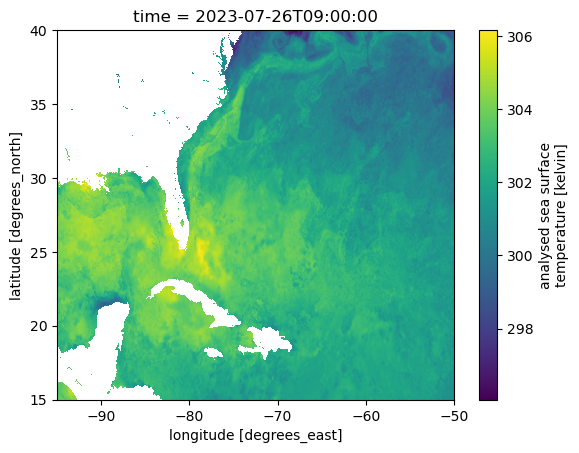

In [6]:
sstdata['analysed_sst'].sel(lat=slice(15,40), lon=slice(-95, -50)).plot()

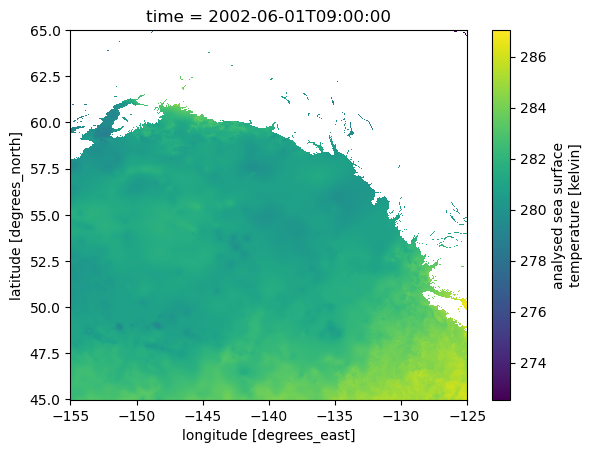

In [5]:
lonbnds = (-155, -125)
sstdata['analysed_sst'].sel(lat=slice(45,65), lon=slice(*lonbnds)).plot()

## 2. Create mean time series of SST and SST-anomalies for the two regions (aggregating in space)

### 2.1 Open data

In the interest of the notebook computations not taking too long, and the fact that mean SST's over larger regions shouldn't change drastically over a few days, we thin out the number of files to load to 3-day frequency rather than 1-day frequency.

In [4]:
# Get one out of every 3 files, starting 3 years from the most recent MUR  file:
years_analyze = 3
murfiles_to_load = fns[slice(-1*365*years_analyze, -1, 3)]

**Opening the files with `open_mfdataset()` is the longest step in this process. Once the files are opened, computations are quick.**

In [5]:
%%time

s3_file_objects = [ fs_s3.open(fpath, mode='rb') for fpath in murfiles_to_load ]
murdata = xr.open_mfdataset(
    s3_file_objects, chunks={'time':1, 'lat':6000, 'lon':6000}, 
    drop_variables=['analysis_error','mask','sea_ice_fraction']
    )

murdata

CPU times: user 1min 48s, sys: 33 s, total: 2min 21s
Wall time: 4min 2s


<xarray.Dataset>
Dimensions:       (time: 365, lat: 17999, lon: 36000)
Coordinates:
  * time          (time) datetime64[ns] 2020-07-24T09:00:00 ... 2023-07-25T09...
  * lat           (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon           (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    analysed_sst  (time, lat, lon) float32 dask.array<chunksize=(1, 6000, 6000), meta=np.ndarray>
    dt_1km_data   (time, lat, lon) timedelta64[ns] dask.array<chunksize=(1, 6000, 6000), meta=np.ndarray>
    sst_anomaly   (time, lat, lon) float32 dask.array<chunksize=(1, 6000, 6000), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

### 2.2 Compute time series of the regional mean SST's and mean anomalies

In [9]:
def regional_spatial_mean(sstdata, latbnds, lonbnds):
    future_result = sstdata.sel(lat=slice(*latbnds), lon=slice(*lonbnds)) # subset
    future_result = future_result.mean(dim=['lat','lon'], skipna=True) # mean
    return future_result.load()

In [10]:
# Sub-tropical western Atlantic region:
latbnds1 = (20, 30)
lonbnds1 = (-82, -72)

# Mid-latitude eastern Pacific region:
latbnds2 = (45, 55)
lonbnds2 = (-137, -127)

In [11]:
%%time

region1_mean_sst = regional_spatial_mean(murdata['analysed_sst'], latbnds1, lonbnds1)
region2_mean_sst = regional_spatial_mean(murdata['analysed_sst'], latbnds2, lonbnds2)

/home/ec2-user/miniconda3/envs/jupyterenv/lib/python3.11/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 22.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/ec2-user/miniconda3/envs/jupyterenv/lib/python3.11/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 22.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 5.99 s, sys: 1.43 s, total: 7.41 s
Wall time: 8.32 s


In [12]:
%%time

region1_mean_anom = regional_spatial_mean(murdata['sst_anomaly'], latbnds1, lonbnds1)
region2_mean_anom = regional_spatial_mean(murdata['sst_anomaly'], latbnds2, lonbnds2)

/home/ec2-user/miniconda3/envs/jupyterenv/lib/python3.11/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 22.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/ec2-user/miniconda3/envs/jupyterenv/lib/python3.11/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 22.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 7.63 s, sys: 1.61 s, total: 9.23 s
Wall time: 10.8 s


Text(0, 0.5, 'SST Anomaly [K]')

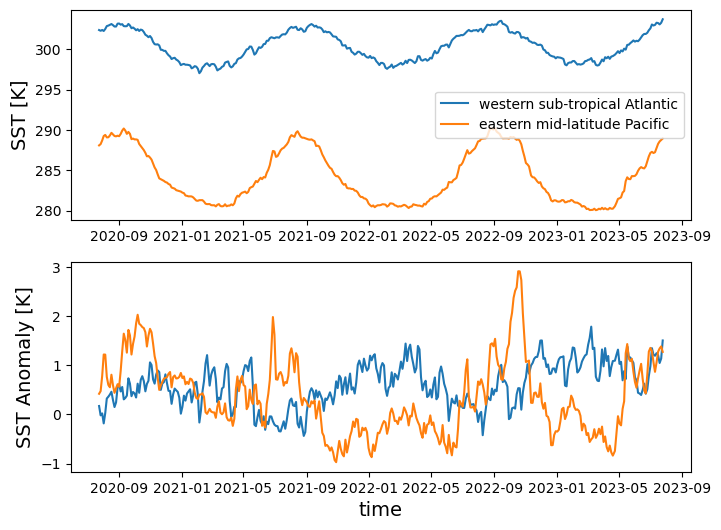

In [14]:
fig1, axes1 = plt.subplots(2, 1, figsize=(8, 6))

axes1[0].plot(region1_mean_sst['time'], region1_mean_sst.values, label='western sub-tropical Atlantic')
axes1[0].plot(region2_mean_sst['time'], region2_mean_sst.values, label='eastern mid-latitude Pacific')

axes1[1].plot(region1_mean_anom['time'], region1_mean_anom.values, label='western sub-tropical Atlantic')
axes1[1].plot(region2_mean_anom['time'], region2_mean_anom.values, label='eastern mid-latitude Pacific')

axes1[0].legend()
axes1[0].set_ylabel('SST [K]', fontsize=14)

axes1[1].set_xlabel('time', fontsize=14)
axes1[1].set_ylabel('SST Anomaly [K]', fontsize=14)

**Is that big jump in SST anomalie for the Pacific a warm pool?**

## 3. Create 2D lat-lon maps of SST variability in each region over the past 5 years (aggregating in time)

### 3.1 Rechunk the data to optimize a time-aggregation function

We have already opened the data in the previous section, so the long step is done!

However, now that we are computing along the time dimension, we will want to chunk our data so that chunks cut through the time dimension as little as possible. Note after running the next block of code that the time dimension will have chunks > 1.

In [16]:
# Chunk sizes of 20 timestamps per chunk:
murdata_timechunked = murdata.chunk({'time':20, 'lat':1000, 'lon':1000})
murdata_timechunked['analysed_sst']

<xarray.DataArray 'analysed_sst' (time: 365, lat: 17999, lon: 36000)>
dask.array<rechunk-merge, shape=(365, 17999, 36000), dtype=float32, chunksize=(20, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-07-24T09:00:00 ... 2023-07-25T09:00:00
  * lat      (lat) float32 -89.99 -89.98 -89.97 -89.96 ... 89.97 89.98 89.99
  * lon      (lon) float32 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -32767
    valid_max:      32767
    comment:        "Final" version using Multi-Resolution Variational Analys...
    source:         MODIS_T-JPL, MODIS_A-JPL, AMSR2-REMSS, AVHRRMTA_G-NAVO, A...

**Note**
```
Xarray in some cases seems to not want to chunk across the time dimension during the initial call to `open_mfdataset()`, so instead we can open the data first and then rechunk the data afterwards using `chunk()`:
```

### 3.2 Compute 2D maps of 5-year standard deviations

In [20]:
def regional_temporal_mean(sstdata, latbnds, lonbnds):
    future_result = sstdata.sel(lat=slice(*latbnds), lon=slice(*lonbnds)) # subset
    future_result = future_result.mean(dim=['time'], skipna=True) # standard deviation
    return future_result.load()

def regional_temporal_std(sstdata, latbnds, lonbnds):
    future_result = sstdata.sel(lat=slice(*latbnds), lon=slice(*lonbnds)) # subset
    future_result = future_result.std(dim=['time'], skipna=True) # standard deviation
    return future_result.load()

In [21]:
%%time

sstmap1 = regional_temporal_mean(murdata_timechunked['analysed_sst'], latbnds1, lonbnds1)
sstmap2 = regional_temporal_mean(murdata_timechunked['analysed_sst'], latbnds2, lonbnds2)

/home/ec2-user/miniconda3/envs/jupyterenv/lib/python3.11/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 22.69 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/ec2-user/miniconda3/envs/jupyterenv/lib/python3.11/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 22.69 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 17.9 s, sys: 6.29 s, total: 24.2 s
Wall time: 31.1 s


In [18]:
%%time

stdmap1 = regional_temporal_std(murdata_timechunked['analysed_sst'], latbnds1, lonbnds1)
stdmap2 = regional_temporal_std(murdata_timechunked['analysed_sst'], latbnds2, lonbnds2)

/home/ec2-user/miniconda3/envs/jupyterenv/lib/python3.11/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 22.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/ec2-user/miniconda3/envs/jupyterenv/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/ec2-user/miniconda3/envs/jupyterenv/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/ec2-user/miniconda3/envs/jupyterenv/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/ec2-user/miniconda3/envs/jupyterenv/lib/python3.11/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 22.70 MiB.
This may cause some slowdown.
Consider scatt

CPU times: user 19.2 s, sys: 6.92 s, total: 26.1 s
Wall time: 32.7 s


/home/ec2-user/miniconda3/envs/jupyterenv/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/ec2-user/miniconda3/envs/jupyterenv/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


Text(0, 0.5, 'SST, 3-year std [K]')

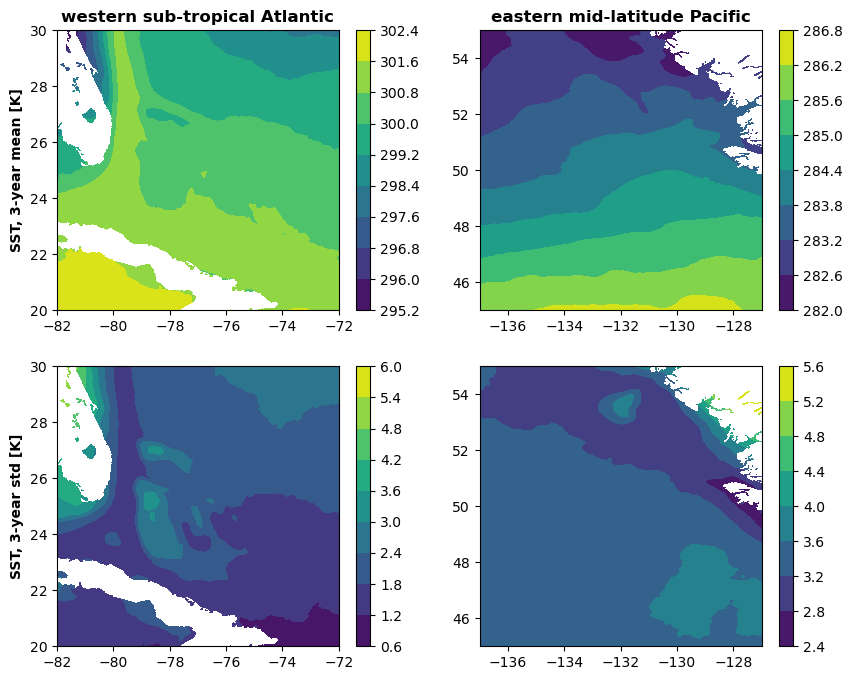

In [29]:
fig2, axes2 = plt.subplots(2, 2, figsize=(10, 8))

# Mean SST maps:
c01 = axes2[0,0].contourf(sstmap1['lon'], sstmap1['lat'], sstmap1.values)
c02 = axes2[0,1].contourf(sstmap2['lon'], sstmap2['lat'], sstmap2.values)
plt.colorbar(c01, ax=axes2[0,0])
plt.colorbar(c02, ax=axes2[0,1])

# SST standard deviation maps:
c11 = axes2[1,0].contourf(stdmap1['lon'], stdmap1['lat'], stdmap1.values)
c12 = axes2[1,1].contourf(stdmap2['lon'], stdmap2['lat'], stdmap2.values)
plt.colorbar(c11, ax=axes2[1,0])
plt.colorbar(c12, ax=axes2[1,1])

axes2[0,0].set_title('western sub-tropical Atlantic', fontweight='bold')
axes2[0,1].set_title('eastern mid-latitude Pacific', fontweight='bold')
axes2[0,0].set_ylabel('SST, %i-year mean [K]' %years_analyze, fontweight='bold')
axes2[1,0].set_ylabel('SST, %i-year std [K]' %years_analyze, fontweight='bold')

## 4. Don't Forget to Close the Client and Cluster!!

In [30]:
client.close()

In [31]:
cluster.close()

## 5. Closing Remarks

* **The longest step by far is opening the collection files with xarray's `open_mfdataset()`. Once the data have been loaded, the sub-sequent computations are relatively quick**. Therefore, code should generally be written to re-open a file as little as possible.

In [14]:
%%time

future_result = murdata['analysed_sst'].sel(lat=slice(20,30), lon=slice(-70, -60)) # subset
future_result = future_result.mean(dim=['lat','lon']) # mean
result = future_result.load()

/home/ec2-user/miniconda3/envs/jupyterenv/lib/python3.11/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 257.66 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 2.57 s, sys: 1.76 s, total: 4.33 s
Wall time: 4.63 s


In [16]:
result

<xarray.DataArray 'analysed_sst' (time: 200)>
array([298.84113, 298.83643, 298.9455 , 298.979  , 299.03622, 299.07697,
       299.22104, 299.25977, 299.33   , 299.39038, 299.4689 , 299.60614,
       299.6441 , 299.7034 , 299.7645 , 299.81793, 299.89716, 299.90695,
       299.937  , 300.03833, 300.01926, 300.01315, 300.06076, 300.22824,
       300.28885, 300.47415, 300.52316, 300.52426, 300.58463, 300.70572,
       300.74347, 300.71246, 300.8731 , 300.91327, 300.95108, 300.95663,
       300.92514, 300.9159 , 300.94656, 301.00586, 300.98334, 300.93686,
       301.0309 , 301.10944, 301.09195, 301.04636, 301.0236 , 300.6746 ,
       301.433  , 301.4301 , 301.3511 , 301.21823, 301.05353, 301.01093,
       301.0289 , 301.05475, 301.12466, 301.2166 , 301.24823, 301.24225,
       301.3087 , 301.42548, 301.57172, 301.6775 , 301.6858 , 301.64706,
       301.92395, 301.74362, 301.68625, 301.63428, 301.70035, 301.78204,
       301.88373, 301.99695, 302.01242, 301.91327, 301.85727, 301.92148,
       302.02325, 302.06992, 302.0912 , 302.15836, 302.23773, 302.24463,
       302.2138 , 302.15378, 302.09164, 301.98935, 301.9572 , 301.8635 ,
       301.80038, 301.7474 , 301.7576 , 301.82672, 301.88507, 302.0168 ,
       302.1486 , 302.1679 , 302.03427, 301.8603 , 301.86166, 301.9417 ,
       301.98178, 301.85614, 301.83334, 301.85193, 301.19492, 301.16492,
       301.15897, 302.1375 , 302.04257, 302.05283, 301.991  , 301.90564,
       301.79883, 301.8023 , 301.8052 , 301.71527, 301.61542, 301.452  ,
       301.38498, 301.4046 , 301.4156 , 301.45905, 301.47498, 301.55206,
       301.58118, 301.52112, 301.455  , 301.47675, 301.5824 , 301.62146,
       301.5419 , 301.51837, 301.54913, 301.64133, 301.69226, 301.62274,
       301.55554, 301.55524, 301.5808 , 301.54727, 301.51852, 301.53192,
       301.5701 , 301.61325, 301.55618, 301.37418, 301.31396, 301.38278,
       301.37274, 301.30643, 301.26077, 301.20694, 301.16034, 301.0442 ,
       300.9134 , 300.9475 , 301.00522, 300.9921 , 300.92572, 300.87094,
       300.84888, 300.75043, 300.66763, 300.56573, 300.44482, 300.42993,
       300.43173, 300.35294, 300.26324, 300.27908, 300.2696 , 300.2306 ,
       300.195  , 300.13354, 300.01834, 300.00552, 300.1127 , 300.12067,
       300.06366, 300.05728, 300.03235, 300.02972, 300.05255, 300.05154,
       300.023  , 299.91605, 299.80533, 299.76016, 299.7546 , 299.79013,
       299.77722, 299.75   , 299.72968, 299.77518, 299.74704, 299.69717,
       299.62775, 299.62592], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2002-06-01T09:00:00 ... 2002-12-17T09:00:00

In [15]:
%%time

s3_file_objects = [ fs_s3.open(fns[i], mode='rb') for i in range(50) ]
sstdata = xr.open_mfdataset(
    s3_file_objects, chunks={'time':1, 'lat':6000, 'lon':6000}, 
    #drop_variables=['analysis_error','mask','sea_ice_fraction']]
    )

results = sstdata['analysed_sst'].mean(dim=['lat','lon'])
results.load()

2023-07-27 18:44:00,459 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
/home/ec2-user/miniconda3/envs/jupyterenv/lib/python3.11/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 250.27 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2023-07-27 18:44:03,411 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-07-27 18:44:11,473 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-07-27 18:44:19,009 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-07-27 18:44:26,079 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


CPU times: user 23.6 s, sys: 11.5 s, total: 35.1 s
Wall time: 37.8 s


<xarray.DataArray 'analysed_sst' (time: 50)>
array([286.77927, 286.81073, 286.81418, 286.81055, 286.784  , 286.7543 ,
       286.73093, 286.70142, 286.68307, 286.67825, 286.6885 , 286.69244,
       286.69852, 286.72073, 286.74268, 286.7751 , 286.81277, 286.83624,
       286.8414 , 286.84143, 286.83743, 286.82742, 286.8161 , 286.8098 ,
       286.8052 , 286.80133, 286.8011 , 286.8194 , 286.81882, 286.81235,
       286.8138 , 286.82913, 286.8091 , 286.78366, 286.76733, 286.76324,
       286.77533, 286.78818, 286.79654, 286.80206, 286.8228 , 286.84515,
       286.86697, 286.8883 , 286.89984, 286.9066 , 286.91885, 286.86548,
       286.87137, 286.86624], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2002-06-01T09:00:00 ... 2002-07-20T09:00:00

2023-07-27 18:44:30,054 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-07-27 18:44:53,004 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-07-27 18:45:17,054 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-07-27 18:45:41,105 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-27 18:46:05,016 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [ ]:
def spatial_mean(data, latbnds, lonbnds):
    data_sub = data.sel(lat=slice(*latbnds), lon=slice(*lonbnds)) # subset
    return data_sub.mean(dim=['lat','lon'])

In [10]:
%%time

def testmean(data):
    data_sub = data.sel(lat=slice(-45,45), lon=slice(-180, -50)) # subset
    return data_sub.mean(dim=['lat','lon'])

#results = data_mf['analysed_sst'].sel(lat=slice(-45,45), lon=slice(-180, -50)) # subset
#results = results.mean(dim=['lat','lon']) # mean


s3_file_objects = [ fs_s3.open(fns[i], mode='rb') for i in range(50) ]
sstdata = xr.open_mfdataset(
    s3_file_objects, chunks={'time':1, 'lat':6000, 'lon':6000}, 
    drop_variables=['analysis_error','mask','sea_ice_fraction']
    )

results = client.submit(testmean, sstdata['analysed_sst'])  # bad
#big_future = client.scatter(sstdata['analysed_sst'])     # good
#results = client.submit(testmean, big_future)  # good
#results = sstdata['analysed_sst'].mean(dim=['lat','lon'])
#results.load()

CPU times: user 9.77 s, sys: 2.86 s, total: 12.6 s
Wall time: 18.2 s


/home/ec2-user/miniconda3/envs/jupyterenv/lib/python3.11/site-packages/distributed/worker.py:2995: UserWarning: Large object of size 2.89 MiB detected in task graph: 
  (<xarray.DataArray 'analysed_sst' (time: 50, lat:  ... AVHRR_Path...,)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


In [11]:
%%time
#client.gather(results).values
results.result().values

CPU times: user 5.54 s, sys: 1.86 s, total: 7.4 s
Wall time: 8.65 s


array([295.84027, 295.8535 , 295.85297, 295.83807, 295.78787, 295.75354,
       295.72382, 295.69296, 295.6723 , 295.6638 , 295.65933, 295.65103,
       295.64966, 295.68182, 295.71323, 295.74152, 295.77487, 295.79486,
       295.788  , 295.7863 , 295.77863, 295.77972, 295.7696 , 295.77005,
       295.7703 , 295.77307, 295.77078, 295.7859 , 295.77335, 295.78018,
       295.7901 , 295.79022, 295.77536, 295.74515, 295.71088, 295.69308,
       295.70413, 295.71893, 295.7305 , 295.73328, 295.72354, 295.72495,
       295.74182, 295.75818, 295.7689 , 295.78342, 295.82147, 295.86142,
       295.7438 , 295.71106], dtype=float32)